In [1]:
!pip install langgraph langchain pandas faiss-cpu langchain-groq sentence-transformers langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.8/145.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.7/109.7 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.7/412.7 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.

In [2]:
from google.colab import userdata
groq_api = userdata.get("groq_api_key")

In [3]:
import pandas as pd
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_core.documents import Document
from langgraph.graph import END, StateGraph
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from typing import TypedDict, List

In [4]:
df = pd.read_csv("/content/failure reason.csv")
# df.head()

docs = []
for _, row in df.iterrows():
    if pd.notna(row["Failure Reason"]) and pd.notna(row["Solution"]):
        docs.append(Document(
            page_content=row["Failure Reason"],
            metadata={"solution": row["Solution"]}
        ))

In [5]:
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vector_store = FAISS.from_documents(docs, embeddings)
retriever = vector_store.as_retriever(search_kwargs={"k": 1})

<ipython-input-5-752e566d6fe3>:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or da

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [6]:
class AgentState(TypedDict):
    input: str
    context: List[dict]
    response: str

In [35]:
llm = ChatGroq(
    groq_api_key = groq_api,
    temperature=0.3,  # Slightly higher temp for creative generation
    # model_name = "llama-3.2-1b-preview",
    model_name="gemma2-9b-it",
)

In [36]:
def retrieve(state: AgentState):
    try:
        relevant_docs = retriever.invoke(state["input"])
        return {"context": relevant_docs}
    except:
        return {"context": []}


In [37]:
def generate_response(state: AgentState):
    try:
        response_template = """**Error:**\n{Error}\n\n**Solution**\n{Solution}\n\n**Test Cases**\n{TestCases}"""
        # Check if solution exists in CSV
        if state["context"] and "solution" in state["context"][0].metadata:
            context = state["context"][0]
            prompt_template = """
            [INST] Given this error and known solution:
            Error: {error}
            Solution: {solution}

            Generate **exactly** 4 structured test cases to validate that solution fixes the issue:
            -2 Positive Test Cases(where solution works correctly)
            -2 Negative Test Casses(where solution fails or is misconfigured)

            Each test case should be unique and structured in this formart:
            1 **Test Scenario**:Describe what is being tested
            2 **Test Steps**:Step-by-Step actions to perform
            3 **Expected Results**:What should happen if the solution is correct
            4 **Pass/Fail Criteria**:How to determine if test passes or fails
            [/INST]
            """
            result = llm.invoke(ChatPromptTemplate.from_template(prompt_template).format(
                error=state["input"],
                solution=context.metadata["solution"]
            )).content
            #parse only resolution steps
            return {"response": response_template.format(
                Error=state["input"],
                Solution=context.metadata["solution"],
                TestCases=result.strip()
            )}
        else:
            return {"response": "**Error**: The error message is unknown and cannot be resolved."}

    except Exception as e:
        return {"response": f"Error processing request: {str(e)}"}

In [38]:
workflow = StateGraph(AgentState)
workflow.add_node("retrieve", retrieve)
workflow.add_node("generate_response", generate_response)
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "generate_response")
workflow.add_edge("generate_response", END)
agent = workflow.compile()

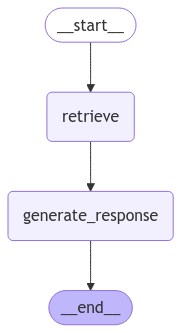

In [39]:
from IPython.display import Image, display

try:
  display(Image(agent.get_graph().draw_mermaid_png()))
except Exception:
  pass

In [40]:
def get_solution(error_message):
    result = agent.invoke({"input": error_message.strip()})
    return result["response"]

In [34]:
#result with llama-3.2-1b-preview
print("=== Exact Error ===")
print(get_solution("The cpu is being highly loaded"))

=== Exact Error ===
**Error:**
The cpu is being highly loaded

**Solution**
Optimize code and use efficient algorithms

**Test Cases**
**Test Cases: Optimizing Code for High CPU Load**

### Test Scenario 1: Positive Test Case - High CPU Load

**Test Steps:**

1. Create a simple Python program that simulates a CPU-intensive task, such as a loop that performs 1000 iterations of a calculation.
2. Run the program on a machine with a high CPU load (e.g., a laptop with multiple cores).
3. Measure the time it takes to complete the task.
4. Run the program on a machine with a low CPU load (e.g., a desktop with a single core).
5. Measure the time it takes to complete the task.

**Expected Results:**

* If the solution works correctly, the time it takes to complete the task should be significantly faster on the high CPU load machine.
* If the solution fails or is misconfigured, the time it takes to complete the task should be the same on both machines.

### Test Case 2: Positive Test Case - CPU 

In [26]:
#results with gemma2-9b-it model
print("\n=== Twiked Error ===")
print(get_solution("The cpu is being highly loaded")) #(original error in file : High CPU usage under load )


=== Twiked Error ===
**Error:**
The cpu is being highly loaded

**Solution**
Optimize code and use efficient algorithms

**Test Cases**
## Test Cases for CPU Load Optimization

**Positive Test Cases:**

**1. Test Scenario:**  Validate CPU load reduction after code optimization for a computationally intensive loop.

**2. Test Steps:**
    -  Run the original, unoptimized code with a large input dataset.
    -  Measure the CPU load using a system monitoring tool (e.g., `top`, `htop`).
    -  Implement the optimized code with efficient algorithms.
    -  Run the optimized code with the same large input dataset.
    -  Measure the CPU load again.

**3. Expected Results:**
    -  The CPU load for the optimized code should be significantly lower than the unoptimized code.

**4. Pass/Fail Criteria:**
    -  Pass: CPU load reduction of at least 20% compared to the unoptimized code.
    -  Fail: CPU load reduction less than 20% or no noticeable difference.

**2. Test Scenario:**  Verify CPU lo